# J1 League Scouting Analysis

The first part of this analysis focuses on attacking options, looking to identify strikers, wingers and attacking midfielders by comparing them based on important attacking metrics (without considering the player’s market value).

In the second part of the analysis, we will be implementing an XGBoost Regression model with Bayesian Hyperparameter Optimisation to identify undervalued players based off their market values, and we’ll create an optimal starting XI of the most undervalued players in the J1 League.

### Importing Libraries & Dataset

In [2]:
# Importing relevant libraries
import pandas as pd # Data manipulation
import numpy as np # Mathematical functions
import seaborn as sns # Data visualisation
from matplotlib import pyplot # Data visualisation
import matplotlib.pyplot as plt # Data visualisation
from scipy.stats import pearsonr # Pearson's Correlation
from xgboost import XGBRegressor # XGBoost Regressor
from sklearn.metrics import mean_squared_error as MSE # RMSE for model evaluation
from sklearn.model_selection import train_test_split, KFold # sklearn modules
# conda install -c conda-forge xgboost
import xgboost as xgb # XGBoost
# conda install -c conda-forge scikit-optimize
from skopt import BayesSearchCV # Bayesian Optimization
from time import time

In [4]:
# Reading excel file as pandas DataFrame
j1_players = pd.read_excel('J1 League.xlsx')
# Removing players who have played less than 90 minutes
j1_players = j1_players[j1_players['Minutes played'] > 90]
# Creating expected goal involvement per 90 column
j1_players['xGI per 90'] = j1_players['xG per 90'] + j1_players['xA per 90']
# Creating successful dribbles per 90 column
j1_players['Successful dribbles per 90'] = j1_players['Dribbles per 90'] * j1_players['Successful dribbles, %']/100
# Creating accurate passes to final 3rd per 90 column
j1_players['Acc. passes to final 3rd per 90'] = j1_players['Passes to final third per 90'] * j1_players['Accurate passes to final third, %']/100
# Creating accurate passes to penalty area per 90 column
j1_players['Acc. passes to penalty area per 90'] = j1_players['Passes to penalty area per 90'] * j1_players['Accurate passes to penalty area, %']/100
# Creating accurate progressive passes per 90 column
j1_players['Acc. progressive passes per 90'] = j1_players['Progressive passes per 90'] * j1_players['Accurate progressive passes, %']/100
# Output
j1_players

,Player,Team,Team within selected timeframe,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,...,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %",xGI per 90,Successful dribbles per 90,Acc. passes to final 3rd per 90,Acc. passes to penalty area per 90,Acc. progressive passes per 90
0,J. Świerczok,Nagoya Grampus,Nagoya Grampus,CF,29,2700000,2024-01-31,14,834,7,...,0.32,66.67,0.00,0,0,0.42,1.834340,1.292835,0.969220,2.156608
1,Y. Muto,Vissel Kobe,Vissel Kobe,"CF, RAMF, RCMF",29,2500000,2023-01-31,18,1593,6,...,0.00,0.00,0.00,1,0,0.31,1.862469,1.133271,0.793305,1.921000
2,Lincoln,Vissel Kobe,Vissel Kobe,CF,21,2400000,2024-01-31,18,673,1,...,0.00,0.00,0.00,0,0,0.27,2.004492,2.269500,0.670000,2.138262
3,Diego Pituca,Kashima Antlers,Kashima Antlers,"LCMF, RCMF, RDMF",29,2200000,2024-01-31,30,2486,2,...,0.11,0.00,1.52,0,0,0.17,1.592629,6.513659,1.956050,7.350002
5,Andrés Iniesta,Vissel Kobe,Vissel Kobe,AMF,37,2000000,2024-01-31,29,2042,7,...,0.26,16.67,1.54,4,100,0.38,2.510298,8.328024,2.686202,7.534240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,K. Ishikawa,Gamba Osaka,Gamba Osaka,GK,29,50000,NaN,5,492,0,...,NaN,NaN,0.00,0,0,0.00,0.000000,0.549375,0.000000,4.206573
595,R. Tsunoda,Yokohama F. Marinos,Yokohama F. Marinos,LCB,22,50000,2025-01-31 00:00:00,4,313,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
596,Y. Minami,Omiya Ardija,Omiya Ardija,GK,42,25000,NaN,7,681,0,...,NaN,NaN,0.00,0,0,0.00,0.000000,0.926550,0.000000,2.776746
598,H. Hogang,Yokohama,Yokohama,"CB, LCB, RCB",28,0,NaN,24,1974,0,...,0.00,0.00,0.00,0,0,0.04,0.180009,2.141184,0.135000,3.327401


# PART 1: Identifying Attacking Options with EDA

### Identifying Strikers

Starting at the top, we’re going to find a striker based off the following metrics:

- **Expected Goals per 90**, arguably the most important metric for a goalscorer, tells us how good a striker is at getting opportunities. The general consensus is that the gap between a player’s ability to *get* chances — so being in the right place at the right time — has a more significant influence on what makes a good striker than their ‘finishing ability’. Expected goals models can be quite complex, but they generally consider:
    - Where is the shot being taken from?
    - How many defenders are in front of them?
    - How has this player done in the past with a similar shot?
    
- **Expected Assists per 90**. Since there are many types of strikers: centre-forwards / false 9’s / inside and outside forwards the role of a striker will vary depending on the team, and some managers want their strikers to be more involved in the build up, which is why expected assists is also important to consider.

- **Expected Goal Involvement per 90** is a summation of expected goals and assists per 90 and this will be an important metric throughout our analysis.

It’s important to adjust these metrics to a per-90 basis, since players will play a varying amount of minutes over the season.

We begin our search for prolific strikers by plotting the distribution of xGI per 90 for strikers.

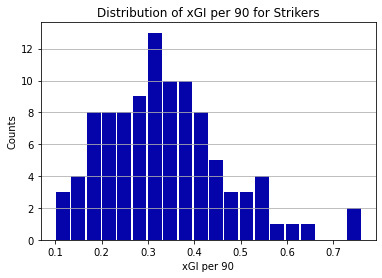

In [5]:
# Subsetting strikers
strikers = j1_players[j1_players['Position'].str.contains('CF')]
# Selecting relevant criteria
strikers = strikers[['Player', 'Team', 'Position', 'Age', 'Market value', 'Minutes played', 'Goals', 'Assists', 'xG per 90', 'xA per 90', 'xGI per 90']].dropna()
# Plotting distribution of xGI per 90 for strikers
strikers['xGI per 90'].plot.hist(grid=True, bins=20, rwidth=0.9, color='#0504aa')
# Setting plot titles
plt.title('Distribution of xGI per 90 for Strikers')
# Setting x-axis & y-axis titles
plt.xlabel('xGI per 90')
plt.ylabel('Counts')
# Adding horizontal grid lines to plot
plt.grid(axis='x', alpha=0.75)

Looking at the distribution of expected goal involvement per 90 for all strikers in the league, we can see that there are two stand out strikers with an astounding 0.7 goal involvements per 90.

In [6]:
# Sorting by xGI
strikers_xGI = strikers.sort_values(by='xGI per 90', ascending=False).head(10)
strikers_xGI.style.background_gradient(subset=['xG per 90', 'xA per 90', 'xGI per 90'], cmap='Blues')

,Player,Team,Position,Age,Market value,Minutes played,Goals,Assists,xG per 90,xA per 90,xGI per 90
6,K. Junker,Urawa Reds,CF,28,2000000,1468,10,1,0.640000,0.120000,0.760000
25,Anderson Lopes,Yokohama F. Marinos,"CF, RWF",28,1200000,1257,9,2,0.680000,0.050000,0.730000
23,Y. Kobayashi,Kawasaki Frontale,"CF, RWF, RW",34,1300000,1179,6,2,0.460000,0.170000,0.630000
26,A. Ueda,Kashima Antlers,CF,23,1200000,2189,17,1,0.540000,0.080000,0.620000
62,Léo Ceará,Yokohama F. Marinos,CF,27,800000,1655,10,5,0.440000,0.150000,0.590000
9,Leandro Damião,Kawasaki Frontale,CF,32,1900000,2493,19,5,0.440000,0.110000,0.550000
175,Douglas Vieira,Sanfrecce Hiroshima,CF,34,500000,1010,5,1,0.410000,0.140000,0.550000
153,K. Chinen,Kawasaki Frontale,CF,27,600000,976,6,0,0.490000,0.050000,0.540000
325,Douglas,Consadole Sapporo,"CF, AMF",27,150000,454,2,0,0.500000,0.030000,0.530000
138,Y. Kamiya,Shimizu S-Pulse,"LW, CF, RW",24,600000,1728,3,7,0.270000,0.250000,0.520000


These players are **Kasper Junker** and **Anderson Lopes**.

They both have 11 goal involvements in a similar amount of minutes, and are both 28 years old, but Lopes has a cheaper price tag according to his Market Value.

Another player to look at here is **Ayase Ueda**, who’s only 23 years old with the 3rd best xG per 90 in the league.

To separate these players we can compare them using another metric, **Key Passes per 90**, with a key pass being a pass that immediately creates a clear goal scoring opportunity for a teammate.

To combine these metrics, we need to check if they are highly correlated, otherwise **Key Passes per 90** wouldn’t be providing any additional information to help distinguish players.

<AxesSubplot:>

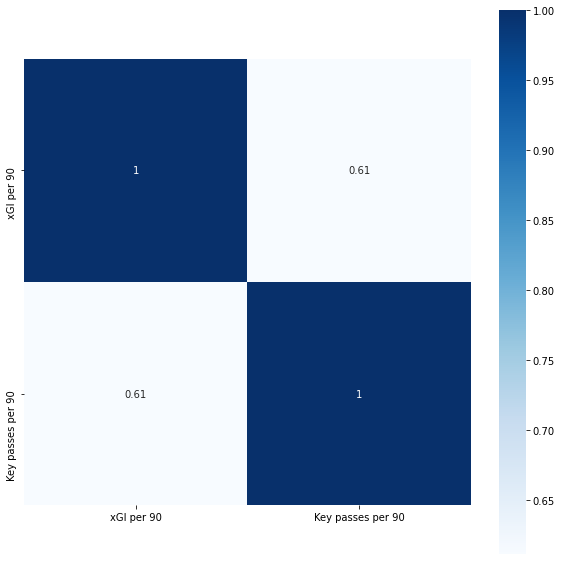

In [7]:
corr_xGI_keypass = j1_players[['xGI per 90', 'Key passes per 90']].dropna()
pyplot.figure(figsize=(10, 10))
sns.heatmap(corr_xGI_keypass.corr(), square=True, annot=True, cmap="Blues")

We can see that key passes per 90 is only moderately positively correlated with xGI per 90, so we can go ahead and plot these metrics against each other to try identify strikers who provide a nice balance of the two metrics.

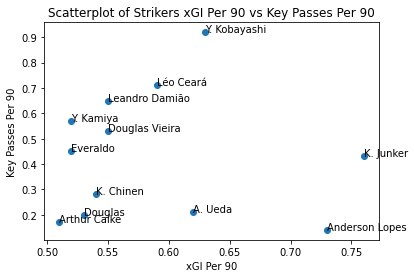

In [8]:
# Subsetting strikers with xGI greater than 0.5
strikers_scatter = j1_players[j1_players['Position'].str.contains('CF')]
strikers_scatter = strikers_scatter[strikers_scatter['xGI per 90'] > 0.5]
# Selecting relevant criteria
strikers_scatter = strikers_scatter[['Player', 'xGI per 90', 'Key passes per 90']].dropna()

# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = strikers_scatter['xGI per 90'], y = strikers_scatter['Key passes per 90'])
# Setting axis title and labels
ax.set_title('Scatterplot of Strikers xGI Per 90 vs Key Passes Per 90')
ax.set_xlabel('xGI Per 90')
ax.set_ylabel('Key Passes Per 90')

# Annotating points in axis with player names
for idx, row in strikers_scatter.iterrows():
    ax.annotate(row['Player'], (row['xGI per 90'], row['Key passes per 90']) )
plt.show()

Ideally we would want players to be in the top right of this graph, if not at the far right or at the top of the plot.

**Kasper Junker** provides a nice balance of both metrics, as does **Yu Kobayashi**.

We’re going to favour xGI over key passes per 90 here and I’m going to suggest **Kasper Junker** as the most exciting prospect in the striker position, followed by **Anderson Lopes** and **Ayase Ueda**. I haven’t included Yu Kobayashi in this list because he’s 34 years old and a player that age is unlikely to adjust well to the physicality of the Premier League.

### Identifying Wingers

Moving on to wingers, we’re going to rank based off the following metrics:

- **Expected Goal Involvement per 90**
- **Key Passes per 90**
- **Crosses to Goalie Box per 90**
- **Successful Dribbles per 90**

We apply a constraint on the number of crosses per 90, as some players who are primarily strikers are listed as also having played on the wing.

In [9]:
# Subsetting wingers
# Including LAMF & RAMF here as teams playing a 4-2-3-1 formation classify wingers as AMF's
wingers = j1_players[j1_players['Position'].str.contains(r'(?:\s|^)LW|LWF|LAMF|RW|RWF|RAMF(?:\s|$)')]
# Removing players who are primarily strikers
wingers = wingers[wingers['Crosses per 90'] > 3]
# Selecting relevant criteria
wingers = wingers[['Player', 'Team', 'Position', 'Age', 'Market value', 'Minutes played', 'Goals', 'Assists', 'xG per 90', 'xA per 90', 'xGI per 90', 'Key passes per 90', 'Crosses to goalie box per 90', 'Successful dribbles per 90']].dropna()
# Sorting by xGI
wingers_xGI = wingers.sort_values(by='xGI per 90', ascending=False).head(10)
wingers_xGI.style.background_gradient(subset=['xGI per 90', 'Key passes per 90', 'Crosses to goalie box per 90', 'Successful dribbles per 90'], cmap='Blues')

,Player,Team,Position,Age,Market value,Minutes played,Goals,Assists,xG per 90,xA per 90,xGI per 90,Key passes per 90,Crosses to goalie box per 90,Successful dribbles per 90
45,K. Mizunuma,Yokohama F. Marinos,"RAMF, RW",32,950000,929,3,6,0.200000,0.360000,0.560000,1.360000,1.360000,1.358470
14,T. Nakagawa,Yokohama F. Marinos,"RAMF, LAMF",29,1500000,1494,5,5,0.170000,0.320000,0.490000,1.020000,0.360000,2.351232
24,Élber,Yokohama F. Marinos,"RAMF, LAMF",29,1200000,2872,7,8,0.210000,0.260000,0.470000,1.000000,0.440000,2.756520
49,Cristiano,V-Varen Nagasaki,"CF, RW",35,900000,2520,7,3,0.260000,0.200000,0.460000,0.610000,0.360000,2.392166
172,T. Takagi,JEF United,"LW, LAMF",30,500000,558,1,3,0.090000,0.330000,0.420000,1.290000,0.810000,2.098636
7,Y. Suzuki,Kashima Antlers,"CF, LAMF",25,2000000,455,2,1,0.190000,0.220000,0.410000,0.590000,0.790000,1.582490
174,Y. Endo,Vegalta Sendai,"RW, RAMF, AMF",33,500000,575,1,3,0.050000,0.320000,0.370000,0.940000,0.630000,1.407304
119,K. Nishizawa,Shimizu S-Pulse,"RW, LW",25,650000,1456,2,3,0.130000,0.230000,0.360000,0.490000,0.490000,1.916376
116,T. Hasegawa,Yokohama,"LWF, LW",28,650000,796,0,1,0.090000,0.260000,0.350000,1.020000,0.680000,3.052855
17,Mateus,Nagoya Grampus,"RW, RAMF, LW",27,1500000,2857,5,2,0.160000,0.190000,0.350000,0.570000,0.720000,3.180720


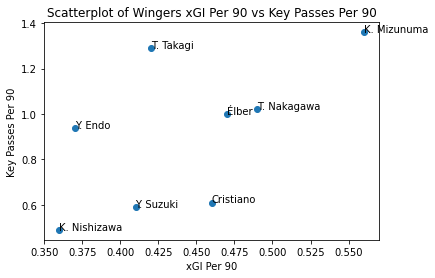

In [10]:
# Subsetting wingers with xGI greater than 0.35
wingers_scatter = wingers[wingers['xGI per 90'] > 0.35]

# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = wingers_scatter['xGI per 90'], y = wingers_scatter['Key passes per 90'])
# Setting axis title and labels
ax.set_title('Scatterplot of Wingers xGI Per 90 vs Key Passes Per 90')
ax.set_xlabel('xGI Per 90')
ax.set_ylabel('Key Passes Per 90')

# Annotating points in axis with player names
for idx, row in wingers_scatter.iterrows():
    ax.annotate(row['Player'], (row['xGI per 90'], row['Key passes per 90']) )
plt.show()

Plotting xGI per 90 against Key Passes per 90 for wingers, we see that **Kota Mizunuma** is the clear favourite with the highest value for both metrics. **Élber** and **Teruhito Nakagawa** also rank very highly in both categories.

To get a more complete view of the wingers, we also plot **Crosses to the Goalie Box per 90** against **Successful Dribbles per 90**, noting that there is only a moderate positive correlation between the variables.

<AxesSubplot:>

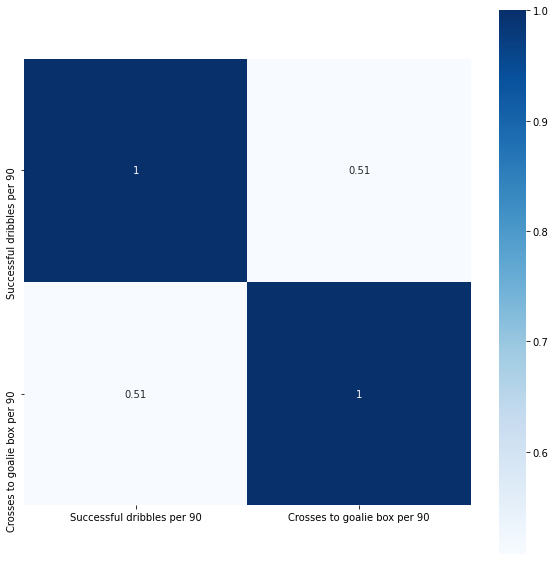

In [11]:
corr_dribbles_crosses = j1_players[['Successful dribbles per 90', 'Crosses to goalie box per 90']].dropna()
pyplot.figure(figsize=(10, 10))
sns.heatmap(corr_dribbles_crosses.corr(), square=True, annot=True, cmap="Blues")

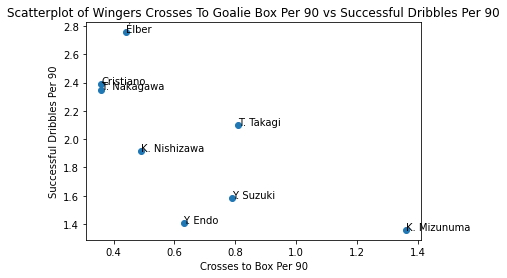

In [12]:
# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = wingers_scatter['Crosses to goalie box per 90'], y = wingers_scatter['Successful dribbles per 90'])
# Setting axis title and labels
ax.set_title('Scatterplot of Wingers Crosses To Goalie Box Per 90 vs Successful Dribbles Per 90')
ax.set_xlabel('Crosses to Box Per 90')
ax.set_ylabel('Successful Dribbles Per 90')

# Annotating points in axis with player names
for idx, row in wingers_scatter.iterrows():
    ax.annotate(row['Player'], (row['Crosses to goalie box per 90'], row['Successful dribbles per 90']) )
plt.show()

We see that **Kota Mizunuma** has the greatest number of crosses into the box by far, but his older age shows a bit in his lower number of successful dribbles per 90.

**Élber** and **Teruhito Nakagawa** are separated here with **Élber** having the most successful dribbles per 90 out of all wingers, and a slightly higher number of crosses into the box per 90.

**Toshiyuki Takagi** looks like an interesting prospect too, as he ranks very highly in key passes per 90 and is very balanced in terms of his successful dribbles and crosses into the box per 90.

**Cristiano** also ranks very highly in terms of his xGI per 90 and his successful dribbles per 90, but at the ripe age of 35 he may not be so appealing to Premier League managers.

### Identifying Attacking Midfielders

Moving into the attacking midfield position, we’re looking for a number 10, the creative midfielder who’s seen as the hub of any teams attacks, and these are the metrics we’re interested in:

- **Key Passes per 90**, arguably the most important metric for a number 10
- **Expected Goal Involvement per 90**
- **Progressive Runs per 90**
- **Accurate Passes to Final 3rd per 90**

In [13]:
# Subsetting attacking mids
attacking_mids = j1_players[j1_players['Position'].str.contains(r'(?:\s|^)AMF(?:\s|$)')]
# Selecting relevant criteria
attacking_mids = attacking_mids[['Player', 'Team', 'Position', 'Age', 'Market value', 'Minutes played', 'Goals', 'Assists', 'xG per 90', 'xA per 90', 'xGI per 90', 'Key passes per 90', 'Progressive runs per 90', 'Acc. passes to final 3rd per 90']].dropna()
# Sorting by key passes per 90
attacking_mids_key_passes = attacking_mids.sort_values(by='Key passes per 90', ascending=False).head(10)
attacking_mids_key_passes.style.background_gradient(subset=['xG per 90', 'xA per 90', 'xGI per 90', 'Key passes per 90', 'Progressive runs per 90', 'Acc. passes to final 3rd per 90'], cmap='Blues')

,Player,Team,Position,Age,Market value,Minutes played,Goals,Assists,xG per 90,xA per 90,xGI per 90,Key passes per 90,Progressive runs per 90,Acc. passes to final 3rd per 90
174,Y. Endo,Vegalta Sendai,"RW, RAMF, AMF",33,500000,575,1,3,0.050000,0.320000,0.370000,0.940000,1.100000,3.444375
8,Marcos Júnior,Yokohama F. Marinos,AMF,29,1900000,2275,8,4,0.330000,0.280000,0.610000,0.910000,0.750000,4.629810
111,Juan Alano,Kashima Antlers,"RW, RAMF, AMF",25,700000,1477,4,3,0.220000,0.220000,0.440000,0.850000,1.710000,2.500878
130,Y. Muto,Kashiwa Reysol,"CF, AMF",33,600000,1539,0,2,0.110000,0.120000,0.230000,0.530000,0.640000,2.517396
11,H. Kiyotake,Cerezo Osaka,"LW, CF, AMF",32,1600000,2576,2,3,0.130000,0.100000,0.230000,0.520000,1.430000,4.892679
145,T. Arano,Consadole Sapporo,"RCMF, CF, AMF",28,600000,1660,0,1,0.070000,0.100000,0.170000,0.430000,1.300000,4.774209
57,Y. Asano,Sanfrecce Hiroshima,"CF, RWF, AMF",25,900000,1955,5,0,0.230000,0.070000,0.300000,0.410000,1.430000,1.333908
5,Andrés Iniesta,Vissel Kobe,AMF,37,2000000,2042,7,5,0.240000,0.140000,0.380000,0.400000,1.540000,8.328024
146,Y. Komai,Consadole Sapporo,"RCMF, LCMF, AMF",29,600000,3437,1,3,0.050000,0.050000,0.100000,0.370000,1.130000,5.894160
155,N. Nomura,Oita Trinita,"RW, LW, AMF",30,550000,732,1,1,0.110000,0.190000,0.300000,0.370000,0.980000,2.338560


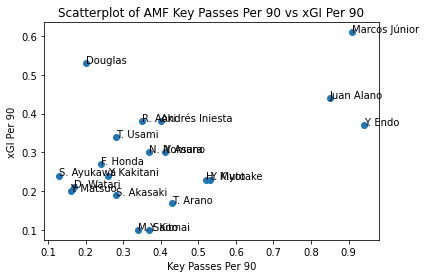

In [14]:
# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = attacking_mids['Key passes per 90'], y = attacking_mids['xGI per 90'])
# Setting axis title and labels
ax.set_title('Scatterplot of AMF Key Passes Per 90 vs xGI Per 90')
ax.set_xlabel('Key Passes Per 90')
ax.set_ylabel('xGI Per 90')

# Annotating points in axis with player names
for idx, row in attacking_mids.iterrows():
    ax.annotate(row['Player'], (row['Key passes per 90'], row['xGI per 90']) )
plt.show()

There are several exciting players to look at here, especially **Marcos Júnior**, who ranks 1st for xGI per 90 and 2nd for key passes per 90.

**Juan Alano** and **Yasuhito Endō** are also exciting options with a very good balance of both metrics.

<AxesSubplot:>

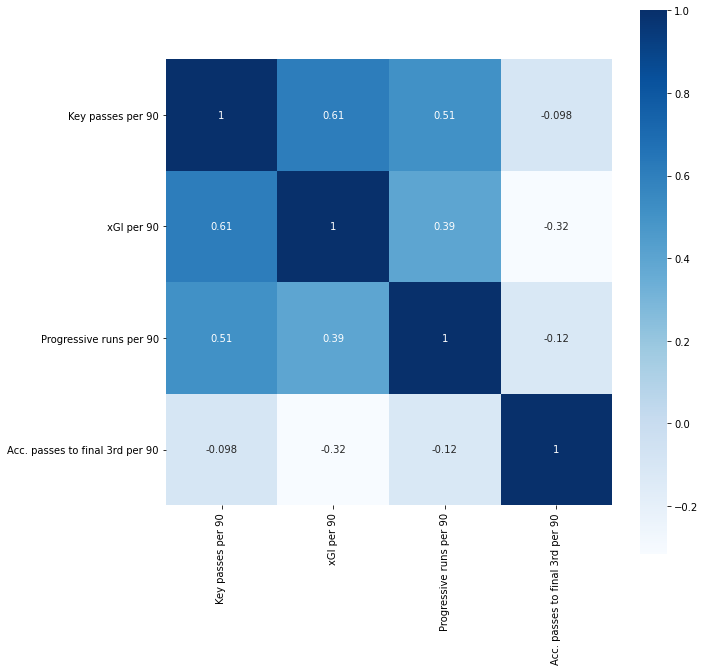

In [15]:
corr_plot = j1_players[['Key passes per 90', 'xGI per 90', 'Progressive runs per 90', 'Acc. passes to final 3rd per 90']].dropna()
pyplot.figure(figsize=(10, 10))
sns.heatmap(corr_plot.corr(), square=True, annot=True, cmap="Blues")

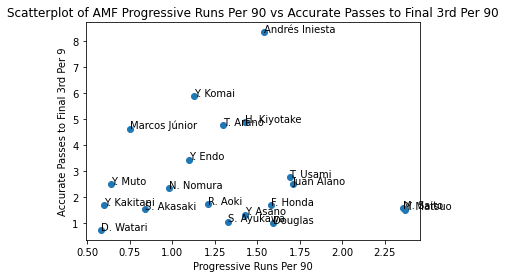

In [16]:
# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = attacking_mids['Progressive runs per 90'], y = attacking_mids['Acc. passes to final 3rd per 90'])
# Setting axis title and labels
ax.set_title('Scatterplot of AMF Progressive Runs Per 90 vs Accurate Passes to Final 3rd Per 90')
ax.set_xlabel('Progressive Runs Per 90')
ax.set_ylabel('Accurate Passes to Final 3rd Per 9')

# Annotating points in axis with player names
for idx, row in attacking_mids.iterrows():
    ax.annotate(row['Player'], (row['Progressive runs per 90'], row['Acc. passes to final 3rd per 90']) )
plt.show()

We can plot **Progressive Runs per 90** against **Accurate Passes to the Final 3rd per 90** to get an idea of which players are great at bringing the ball forwards into dangerous areas, and there’s no real stand out options here.

We can see **Andrés Iniesta** is still showing his class at 37 years old, but the 3 players who stood out in the previous plot are in and amongst the other players here. 

We will list these three players: **Marcos Júnior**, **Juan Alano** and **Yasuhito Endō** as the best options in the attacking midfield position, favouring key passes and xGI per 90 as the most important metrics here.

# PART 2: Identifying Undervalued Players using XGBoost Regressor with Bayesian Hyperparameter Optimisation

Moving on to the second part of our analysis, we now start to consider a players Market Value to determine which players are being overlooked and undervalued by the market.

It’s important to note that these Market Value figures are not representative of a player's actual value, and as different clubs will value certain players differently, there is no such thing as an inherently quantifiable market value for a player.

We’ll be using an XGBoost Regressor (short for Extreme Gradient Boosting), which is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient Boosting trains various models sequentially, using decision trees as the base weak learner. The trees are added one at a time, and existing trees in the model are not changed, while each new tree helps to correct errors made by previously trained tree.

A gradient descent procedure is used to minimise the loss when adding trees. After calculating error or loss, the parameters of the tree are modified to minimise that error.

So, Gradient Boosting is essentially gradient descent except that instead of taking a step in the gradient direction, you take an approximate step in the gradient direction by training a model to predict the gradient given the data.

XGBoost has become the go-to model in many Kaggle competitions due to it’s execution speed and powerful predictive performance when working on tabular datasets for predictive modeling problems, which is why we’re using it here.

### Player Market Value

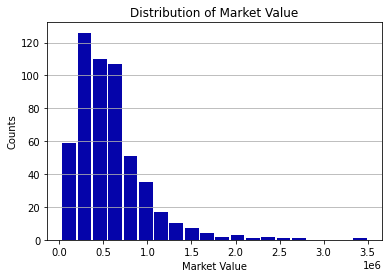

In [17]:
# Removing players with market value = 0
MV = j1_players[j1_players['Market value'] != 0]
# Plotting distribution of market value
MV['Market value'].plot.hist(grid=True, bins=20, rwidth=0.9, color='#0504aa')
# Setting plot titles
plt.title('Distribution of Market Value')
# Setting x-axis & y-axis titles
plt.xlabel('Market Value')
plt.ylabel('Counts')
# Adding horizontal grid lines to plot
plt.grid(axis='x', alpha=0.75)

In [18]:
# Average market value
np.mean(MV['Market value'])

577560.52141527

In [19]:
# Players with highest market value
MV.sort_values(by='Market value', ascending=False).head()

,Player,Team,Team within selected timeframe,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,...,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %",xGI per 90,Successful dribbles per 90,Acc. passes to final 3rd per 90,Acc. passes to penalty area per 90,Acc. progressive passes per 90
380,H. Sakai,Urawa Reds,Urawa Reds,RB,31,3500000,2023-01-31 00:00:00,20,1757,2,...,0.00,0.00,0.0,0,0,0.19,0.462888,2.922948,1.125194,5.175050
0,J. Świerczok,Nagoya Grampus,Nagoya Grampus,CF,29,2700000,2024-01-31,14,834,7,...,0.32,66.67,0.0,0,0,0.42,1.834340,1.292835,0.969220,2.156608
1,Y. Muto,Vissel Kobe,Vissel Kobe,"CF, RAMF, RCMF",29,2500000,2023-01-31,18,1593,6,...,0.00,0.00,0.0,1,0,0.31,1.862469,1.133271,0.793305,1.921000
2,Lincoln,Vissel Kobe,Vissel Kobe,CF,21,2400000,2024-01-31,18,673,1,...,0.00,0.00,0.0,0,0,0.27,2.004492,2.269500,0.670000,2.138262
381,A. Scholz,Urawa Reds,Urawa Reds,LCB,29,2300000,2023-06-30 00:00:00,22,1948,1,...,0.00,0.00,0.0,1,100,0.05,0.553361,3.970043,0.091685,5.034688


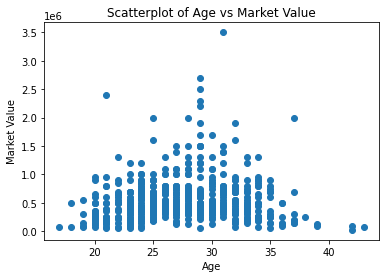

In [20]:
# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = MV['Age'], y = MV['Market value'])
# Setting axis title and labels
ax.set_title('Scatterplot of Age vs Market Value')
ax.set_xlabel('Age')
ax.set_ylabel('Market Value')
plt.show()

## XGBoost Regressor with Bayesian Hyperparameter Optimisation

The steps to implementing this algorithm are as follows:

1. First, we subset the dataset by position, as different metrics will be used to quantify a players value depending on their position on the field
2. Then, we split the data into training & test sets for training and evaluating our model.
3. We create an instance of the XGBoost model using the `xgboost` package in python
4. And we perform Bayesian optimization over the hyper parameters using the `BayesSearchCV` function in pythons scikit-optimise package. This `BayesSearchCV` function implements a “fit” and a “score” method using a cross-validated search over the parameter settings to optimise the parameters.
5. We then fit the model with it’s optimised parameters to the training data set and calculate the model’s performance using a Root Mean Squared Error, which tells us the average distance between the model's predicted values and the actual values
6. Finally, we identify which players are the most undervalued by finding the players with the greatest negative difference between their predicted market value and their actual market value.

In [18]:
def undervalued_players(pos):
    # Subsetting by position
    position = MV[MV['Position'].str.contains(pos)]
    # Splitting data into input and output columns
    X = position.filter(like='per 90', axis=1) # Subsetting variables to a per 90 basis
    y = position['Market value']
    # Converting the dataset into a Dmatrix that XGBoost supports
    data_dmatrix = xgb.DMatrix(data=X,label=y)

    # Splitting the data into training (80%) & test sets (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Defining search space for XGBoost hyperparameters
    xgboost_params = {
        'learning_rate':[0.01,0.75, 'uniform'],
        'n_estimators':list(range(3,300,3)),
        'max_depth':list(range(1,50)),
        'reg_lambda':[1.0,30.0,'uniform'],
        'reg_alpha':[0.0,20.0,'uniform'],
        'min_child_weight': list(range(1,15)),
        'subsample': [0.0,1.0,'uniform'],
        'colsample_bytree': [0.0,1.0,'uniform'],
    }

    # Defining our model
    estimator = xgb.XGBRegressor()
    # K-fold Cross Validation
    cv = KFold(n_splits = 5, shuffle = False)
    # Number of Bayesian trial runs (more iterations = better model, longer runtime)
    n_iter = 10
    # Number of Bayesian trials to run simultaneously (fewer iterations = better model, longer runtime)
    n_points = 4
    # Bayesian Search
    search = BayesSearchCV(
        estimator = estimator,
        n_iter = n_iter,
        n_points = n_points,
        search_spaces = xgboost_params,
        n_jobs = -1,
        cv = cv)

    # Measuring runtime, starting here
    start_time = time()

    # Fitting Model
    search = search.fit(X_train, y_train)

    # Generating train predictions
    y_pred_train = search.predict(X_train)
    # Generating Test Predictions
    y_pred_test = search.predict(X_test)

    # Measuring runtime, ending here
    end_time = time()
    # Printing runtime
    print("{0:.2f} Minutes".format((end_time - start_time)/60))

    # Using these parameters in a model
    model = xgb.XGBRegressor().set_params(**dict(search.best_params_))

    # Fitting the model
    model.fit(X_train, y_train)
    # Predict the model
    pred = model.predict(X_test)
    # RMSE Computation
    rmse = np.sqrt(MSE(y_test, pred))
    print("RMSE : % f" %(rmse))

    ### Identifying the most undervalued player in that position
    # Finding the difference between the predicted and actual market values
    MV_diff = (y_test-y_pred_test).sort_values().head()
    # Converting to pandas dataframe
    MV_diff = pd.DataFrame(MV_diff)
    # Renaming market value column to 'Over/Undervaluation'
    MV_diff = MV_diff.rename({'Market value': 'Over/Undervaluation'}, axis=1)
    # Creating dataframe of player details
    player_details = j1_players[['Player', 'Team', 'Position', 'Age', 'Market value']]
    # Converting to pandas dataframe
    player_details = pd.DataFrame(player_details)
    # Appending player details to MV over/undervaluation
    undervalued = MV_diff.join(player_details)
    # Re-ordering columns
    cols = undervalued.columns.tolist()
    # Placing first column as last column
    cols = cols[1:] + cols[0:1]
    undervalued = undervalued[cols]
    # Output
    return undervalued

## Creating an Optimal Starting XI of Undervalued Players

Using this algorithm, we create this optimal starting XI of undervalued players.

Note that the players here aren’t necesarily the best players in the league in their positions, they are the players that are undervalued that the market has overlooked, when their stats suggest that they are worth more than they cost.

This analysis is therefore targetting towards teams who are dealing with a lower budget and seek to find value in the market.

### STRIKER
Starting up top we have **Fuchi Honda**, a 20 year old striker with a market value of £300,000 and our algorithm says he’s worth well over double that at around £700,000 (£698,654.19).

In [19]:
undervalued_players(pos = 'CF')

2.25 Minutes
RMSE :  502354.274766


,Player,Team,Position,Age,Market value,Over/Undervaluation
273,F. Honda,Sagan Tosu,"CF, RW, AMF",20,300000,-398654.18750
337,S. Nakamura,Yokohama,"AMF, LCMF, CF",43,75000,-293017.03125
138,Y. Kamiya,Shimizu S-Pulse,"LW, CF, RW",24,600000,-234012.81250
118,M. Saito,Nagoya Grampus,"LW, CF, AMF",31,650000,-219570.75000
324,H. Jogo,Avispa Fukuoka,"CF, LW",35,150000,-218017.03125


### LEFT WINGER

Next to him we have **Kazuki Fujimoto**, a 23 year old left winger with a market value of £100,000 and our algorithm says he’s worth over 4 times than that at around £440,000 (£441,947.66).

In [21]:
undervalued_players(pos = r'(?:\s|^)LW|LWF|LAMF(?:\s|$)')

2.32 Minutes
RMSE :  340083.366834


,Player,Team,Position,Age,Market value,Over/Undervaluation
334,K. Fujimoto,Oita Trinita,"LB, LW, LWF",23,100000,-341947.65625
257,H. Yamada,Cerezo Osaka,"CF, RW, LW",22,350000,-324065.93750
547,K. Kurokawa,Gamba Osaka,"LB, LWB",24,250000,-182282.56250
278,Y. Iwasaki,Sagan Tosu,"CF, LWB",23,300000,-175935.40625
279,H. Tameda,Cerezo Osaka,"LAMF, LW",28,300000,-141947.65625


### RIGHT WINGER

On the other side we have **Jun Nishikawa**, a 20 year old right winger with a market value of £300,000 and our algorithm says he’s worth over double that at around £680,000 (£679,743.94).

We’re starting to see a pattern emerge here, with our algorithm heavily favouring younger players. This is most likely due to the fact that a player’s market value will increase with more experience, and isn’t necesarilly a bad thing as most teams seek to invest in young talent with a lot of potential.

In [22]:
undervalued_players(pos = r'(?:\s|^)RW|RWF|RAMF(?:\s|$)')

2.29 Minutes
RMSE :  253457.992495


,Player,Team,Position,Age,Market value,Over/Undervaluation
265,J. Nishikawa,Sagan Tosu,"RW, CF",20,300000,-379743.9375
344,Y. Kitajima,Avispa Fukuoka,"LW, RCMF, RW",21,75000,-340353.1250
273,F. Honda,Sagan Tosu,"CF, RW, AMF",20,300000,-291595.2500
326,K. Konno,Tokyo,"RW, RWF, RAMF",24,150000,-265353.1250
315,E. Oti,Melaka United,"LW, RW, CF",25,175000,-240353.1250


### ATTACKING MIDFIELDER

Moving onto the midfield, we’re going to identify an attacking midfielder, a central box-to-box mid like a number 8, and a defensive holding mid like a number 6.

Our attacking midfielder is **Hiroto Yamami**, a 22 year old attacking midfield with a market value of £150,000 and our algorithm says he’s over 3 times that at around £500,000 (£493,869.06).

In [23]:
undervalued_players(pos = r'(?:\s|^)AMF(?:\s|$)')

2.28 Minutes
RMSE :  594185.692442


,Player,Team,Position,Age,Market value,Over/Undervaluation
323,H. Yamami,Gamba Osaka,"CF, RW, AMF",22,150000,-343869.06250
155,N. Nomura,Oita Trinita,"RW, LW, AMF",30,550000,-87159.18750
111,Juan Alano,Kashima Antlers,"RW, RAMF, AMF",25,700000,138327.37500
94,K. Omori,Júbilo Iwata,"RW, LW, AMF",29,700000,206130.93750
90,D. Watari,Avispa Fukuoka,"CF, AMF",28,700000,271178.28125


### CENTRE MIDFIELDER

Our central midfielder is **Yasuhito Endo**, a 42 year old centre mid with 152 caps for Japan and 902 appearances in his career.

The market values him at £100,000 and our algorithm says he is worth **6 TIMES** that at around £600,000 (£602,999.88), by far the biggest gap in our models predictions so far. It makes sense that older players are being under valued too, as they are expected to decline every year they play on.

In [24]:
undervalued_players(pos = r'(?:\s|^)LCMF|RCMF(?:\s|$)')

2.53 Minutes
RMSE :  509312.079471


,Player,Team,Position,Age,Market value,Over/Undervaluation
336,Y. Endō,Júbilo Iwata,"LCMF, RCMF",42,100000,-502999.87500
133,T. Seko,Kawasaki Frontale,"LCMF, RCMF",24,600000,-395115.93750
269,H. Miyuki,Omiya Ardija,"DMF, LCMF",28,300000,-315900.43750
169,Rhayner,Sanfrecce Hiroshima,"LCMF, RCMF",31,500000,-181147.37500
295,K. Haneda,Oita Trinita,RCMF,24,250000,-179843.03125


### DEFENSIVE MIDFIELDER

We see this trend of older players being undervalued again in the defensive mid position as we have **Shingo Tomita**, a 35 year old CDM with a market value of £250,000 and our algorithm says he is worth over 2 times that at around £590,000 (£588,383.44). 

In [25]:
undervalued_players(pos = r'(?:\s|^)DMF|LDMF|RDMF(?:\s|$)')

2.46 Minutes
RMSE :  272938.872943


,Player,Team,Position,Age,Market value,Over/Undervaluation
285,S. Tomita,Vegalta Sendai,"RCMF, LCMF, RDMF",35,250000,-338383.4375
162,K. Iwao,Urawa Reds,"LCMF, LDMF, RDMF",33,550000,-306963.8750
234,K. Okuno,Gamba Osaka,"RCMF, LCMF, DMF",21,400000,-257321.5000
149,J. Fujita,Yokohama F. Marinos,"RCMF, LDMF, LCMF",20,600000,-177408.6875
261,R. Nakamura,Kashima Antlers,"DMF, RCMF",24,350000,-166955.7500


### LEFT BACK

Moving into the defence, our left back is **Eijiro Takeda**, a 33 year old left back with a market value of £175,000 and our algorithm says he is worth almost 3 times that at £515,000 (£515,552.13).

In [28]:
undervalued_players(pos = r'(?:\s|^)LB|LWB(?:\s|$)')

2.56 Minutes
RMSE :  191686.977128


,Player,Team,Position,Age,Market value,Over/Undervaluation
565,E. Takeda,Yokohama,"LB, LWB",33,175000,-340552.12500
575,K. Bangunagande,Tokyo,LB,20,125000,-311207.31250
292,S. Takahashi,V-Varen Nagasaki,"RB, LWB",31,250000,-279237.37500
528,R. Okui,V-Varen Nagasaki,"LB, RB",31,300000,-251360.18750
278,Y. Iwasaki,Sagan Tosu,"CF, LWB",23,300000,-151713.71875


### RIGHT BACK

On the other side is **Yota Sato**, a 23 year old right back with a market value of £125,000 with our algorithm saying he is worth over 4 times that at around £520,000 (£521,863.72).

In [29]:
undervalued_players(pos = r'(?:\s|^)RB|RWB(?:\s|$)')

2.25 Minutes
RMSE :  191574.899795


,Player,Team,Position,Age,Market value,Over/Undervaluation
577,Y. Sato,Gamba Osaka,"RCB, RB, LCB",23,125000,-396863.71875
558,K. Iwatake,Yokohama,"RCB, RB, LCB",25,200000,-201309.40625
536,K. Yanagisawa,Gamba Osaka,"RB, RWB",25,300000,-128084.34375
487,Y. Koide,Oita Trinita,"RCB, RB, RWB",27,400000,-125234.06250
292,S. Takahashi,V-Varen Nagasaki,"RB, LWB",31,250000,-93756.65625


### CENTRE BACKS

Our first centre back is **Hidenori Ishii**, a 36 year old with a market value of £125,000 with our algorithm saying he is worth almost 5 times that at around £600,000 (£608,884.50).

Our other centre back is **Hideto Takahashi**, a 34 year old with a market value of £250,000 with our algorithm saying he is worth almost 3 times that at around £680,000 (£683,202.88).

In [30]:
undervalued_players(pos = r'(?:\s|^)CB|LCB|RCB(?:\s|$)')

2.34 Minutes
RMSE :  365224.808678


,Player,Team,Position,Age,Market value,Over/Undervaluation
576,H. Ishii,Tokushima Vortis,LCB,36,125000,-483884.5000
540,H. Takahashi,Yokohama,"CB, LCMF, RCMF",34,250000,-433202.8750
532,Y. Hakamata,Júbilo Iwata,"LCB, LB",25,300000,-360004.8125
229,L. Osaki,Vissel Kobe,"DMF, LDMF, RCB",30,400000,-336896.0625
584,M. Inoha,NaN,RCB,36,100000,-248569.5000


### GOALKEEPER

Finally we have **Kenta Tanno**, a 35 year old goalkeeper with a market value of £50,000 with our algorithm saying he is worth over 9 TIMES that at around £460,000 (£459,232.03).

The estimates for goalkeeper valuations don’t seem to be realistic here, suggesting that a more specific algorithm may be needed for goalkeepers.

In [31]:
undervalued_players(pos = r'(?:\s|^)GK(?:\s|$)')

2.26 Minutes
RMSE :  226854.501393


,Player,Team,Position,Age,Market value,Over/Undervaluation
593,K. Tanno,Kawasaki Frontale,GK,35,50000,-409232.03125
566,T. Kodama,Tokyo,GK,34,175000,-353306.12500
562,T. Sugeno,Consadole Sapporo,GK,37,200000,-248443.15625
486,W. Popp,Machida Zelvia,GK,27,400000,-138704.56250
473,G. Hatano,Tokyo,GK,23,500000,-133718.75000


## Undervalued XI

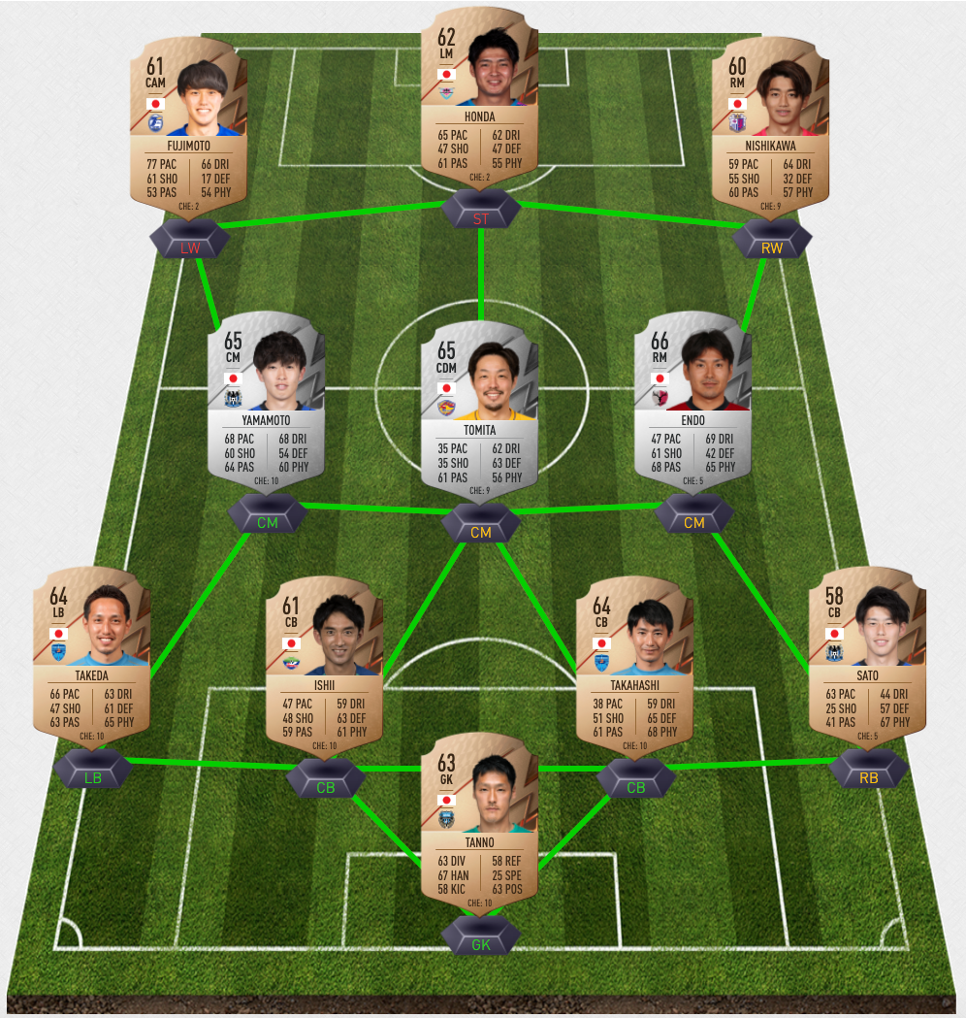